In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
import itertools
from sklearn.metrics import accuracy_score, mean_squared_error
from functools import reduce
import operator
import matplotlib.pyplot as plt

# PART 1

In [213]:
df_movies = pd.read_csv('/kaggle/input/movielens-1m-dataset/movies.dat', sep = "::", names = ['MovieID', 'Title', 'Genres'], encoding='latin-1', engine='python')
df_ratings = pd.read_csv('/kaggle/input/movielens-1m-dataset/ratings.dat', sep = "::", names = ['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1', engine='python')
df_users = pd.read_csv('/kaggle/input/movielens-1m-dataset/users.dat', sep = "::", names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1', engine='python')

In [214]:
df_users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [215]:
df_ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [216]:
df_movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [217]:
def convert_movie_id_to_index(movie_id):
    return int(df_movies.loc[df_movies['MovieID'] == movie_id].index[0])

In [218]:
ratings = np.zeros((len(df_users.index), len(df_movies.index)))

for index, row in df_ratings.iterrows():
    ratings[row['UserID']-1, convert_movie_id_to_index(row['MovieID'])] = row['Rating']

Build a matrix of movie genres

In [219]:
genres = list(dict.fromkeys(reduce(operator.concat, df_movies['Genres'].str.split('|').to_list())))

movie_genres = np.zeros((len(df_movies.index), len(genres)))

for index, row in df_movies.iterrows():
    gen = row['Genres'].split('|')
    for genre in gen:
        movie_genres[convert_movie_id_to_index(row['MovieID']), genres.index(genre)] = 1

In [220]:
ratings_with_user_averages = np.copy(ratings)

for i in range(0, len(df_users.index)):
    user_mean = ratings_with_user_averages[i][ratings_with_user_averages[i] > 0].mean()
    ratings_with_user_averages[i][ratings_with_user_averages[i] == 0] = user_mean

In [221]:
print(ratings_with_user_averages)

[[5.         4.18867925 4.18867925 ... 4.18867925 4.18867925 4.18867925]
 [3.71317829 3.71317829 3.71317829 ... 3.71317829 3.71317829 3.71317829]
 [3.90196078 3.90196078 3.90196078 ... 3.90196078 3.90196078 3.90196078]
 ...
 [3.8        3.8        3.8        ... 3.8        3.8        3.8       ]
 [3.87804878 3.87804878 3.87804878 ... 3.87804878 3.87804878 3.87804878]
 [3.         3.57771261 3.57771261 ... 3.57771261 3.57771261 3.57771261]]


In [222]:
X_train = ratings_with_user_averages[100:]
X_test = ratings_with_user_averages[:100]

In [223]:
model = NMF(n_components=200,beta_loss='frobenius',
            random_state = 101).fit(X_train)
H = model.components_

Reconstruct X_test as 'predictions' (user x movie matrix with ratings where blanks are set to mean for user).

In [224]:
W = model.transform(X_test).T
print(W.shape)
predictions = np.dot(H.T,W)

print(predictions.T)
print(X_test)

(200, 100)
[[4.32364955 4.16576119 4.17514798 ... 4.16615793 4.21496934 4.19107087]
 [3.86887722 3.69473895 3.63644405 ... 3.69571026 3.76028156 3.74424387]
 [3.99166043 3.88987888 3.89757173 ... 3.88121551 3.89711779 3.90550464]
 ...
 [3.91037493 3.78171423 3.75058902 ... 3.78267223 3.81033748 3.80360376]
 [3.47150614 3.1562457  3.17480081 ... 3.22001181 3.23907776 3.21179434]
 [3.11319384 2.98634974 2.98660404 ... 3.02681236 3.01388095 3.02355449]]
[[5.         4.18867925 4.18867925 ... 4.18867925 4.18867925 4.18867925]
 [3.71317829 3.71317829 3.71317829 ... 3.71317829 3.71317829 3.71317829]
 [3.90196078 3.90196078 3.90196078 ... 3.90196078 3.90196078 3.90196078]
 ...
 [3.8        3.8        3.8        ... 3.8        3.8        3.8       ]
 [3.         3.21495327 3.21495327 ... 3.21495327 3.21495327 3.21495327]
 [3.02631579 3.02631579 3.02631579 ... 3.02631579 3.02631579 3.02631579]]


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Build predictions list from above predict RMSE.

In [225]:
to_predict = df_ratings[df_ratings['UserID'] < 100]
y_true = to_predict['Rating'].to_list()
y_pred = []
print(predictions.shape)
for index, row in to_predict.iterrows():
    y_pred += [predictions.T[row['UserID']-1, convert_movie_id_to_index(row['MovieID'])]]
    
print('Predictions : ' + str(y_pred[:10]))
print('True : ' + str(y_true[:10]))

rmse = mean_squared_error(y_true, y_pred)
print('RMSE : ' + str(rmse))

(3883, 100)
Predictions : [4.364130646453508, 4.111280323544709, 4.238801590107731, 4.233686265989772, 4.319004044212079, 4.435313208143991, 4.213405078388304, 4.273509044562177, 4.184491089758348, 4.357307059573346]
True : [5, 3, 3, 4, 5, 3, 5, 5, 4, 4]
RMSE : 0.8972544857588992


In [226]:
X_test_blanked = np.copy(X_test)

for index, row in to_predict.iterrows():
    X_test_blanked[row['UserID']-1, convert_movie_id_to_index(row['MovieID'])] = X_test[row['UserID']-1].mean()

Compare with same data where true ratings are masked with mean value.

In [227]:
y_pred = []
W = model.transform(X_test_blanked).T
predictions_blanked = np.dot(H.T,W)

for index, row in to_predict.iterrows():
    y_pred += [predictions_blanked.T[row['UserID']-1, convert_movie_id_to_index(row['MovieID'])]]
    
print('First 10 predictions : ' + str(y_pred[:10]))
print('First 10 true ratings : ' + str(y_true[:10]))

rmse_blanked = mean_squared_error(y_true, y_pred)
print('RMSE : ' + str(rmse_blanked))

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


First 10 predictions : [4.361948138863764, 4.1333764519371945, 4.198164996903395, 4.242341295694039, 4.257043908800313, 4.460055157744653, 4.198145877281272, 4.239424267572464, 4.185048562539119, 4.312549917411201]
First 10 true ratings : [5, 3, 3, 4, 5, 3, 5, 5, 4, 4]
RMSE : 1.026089726420725


Compare with RMSE where all predictions are set to mean value for user.

In [228]:
y_pred_as_mean = []

for index, row in to_predict.iterrows():
    y_pred_as_mean += [df_ratings[df_ratings['UserID'] == row['UserID']].groupby('UserID').mean()['Rating']]

rmse_user_average = mean_squared_error(y_true, y_pred_as_mean)
print('RMSE : ' + str(rmse_user_average))

RMSE : 1.0447352392533193


And finally RMSE where all predictions are set to 3.

In [229]:
y_pred_as_three = [3] * 12900

rmse_all_threes = mean_squared_error(y_true, y_pred_as_three)
print('RMSE : ' + str(rmse_all_threes))

RMSE : 1.6192248062015504


Below chart shows the RMSE (Root Mean Squared Deviation) of the different approaches.

RMSE, as we know, is the square root of the sum of squared differences between the true values and the predicted values:

$\sqrt{\sum_{i=1}^{n}{\frac{(\hat{y_i}-y_i)^2}{n}}}$

The reason we want to square the differences and the the square root of it all is that we want the absolute value of the differences between the predicted values and the true values. If we did not use the squared differences they might cancel each other out since some could be negative and others positive.

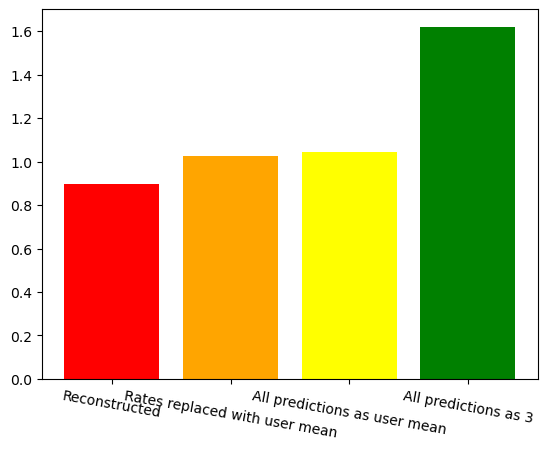

In [230]:
fig, ax = plt.subplots()

plt.bar(['Reconstructed','Rates replaced with user mean','All predictions as user mean','All predictions as 3'], 
        [rmse, rmse_blanked, rmse_user_average, rmse_all_threes], color=['red', 'orange','yellow','green'])
plt.xticks(rotation=-10)
plt.show()

# PART 2

As we see above the Non-negative Matrix Factorization does not work brilliantly on this dataset. In fact for predictions on unknown data it seems to be only marginally better than just guessing on the user average.

It seems the sparsity of information is preventing the method from working optimally (except maybe as a compression method). If that is the case then grouping the users  and/or movies into smaller subsets and building models specifically for those subsets would reduce the sparcity and could improve accuracy.